# 1.Installing dependancies and load data
* inputs - comments 
* labels - according to toxicity for eg non toxic,moderatly toxic,severely toxic and racist


In [1]:
import os 
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(os.path.join('jigsaw-comments-toxicity','train.csv','train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 2.Preprocessing data

In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
MAX_WORDS = 200000 #No of words in the vocab

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS,output_sequence_length=1800,output_mode='int')

In [14]:
vectorizer.adapt(X.values)

In [15]:
vectorized_text = vectorizer(X.values) #It will learn all thw words in our vocab #X.values - numpy array

In [16]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [19]:
#creating a tensorflow data pipeline
#MCSBAP - map,cache,shufle,batch,prefetch -ways to insantiate data pipeline - from_tensor_slices,list_files
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #helps prevent bottleneck

In [24]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [25]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.1))

In [33]:
train_generator = train.as_numpy_iterator()

In [34]:
train_generator.next()

(array([[   76,    59,     8, ...,     0,     0,     0],
        [23340,     9,     6, ...,     0,     0,     0],
        [   14,  5239,   388, ...,     0,     0,     0],
        ...,
        [27159,     2,   251, ...,     0,     0,     0],
        [   88,     7,    65, ...,     0,     0,     0],
        [  103,  3722,     8, ...,     0,     0,     0]], dtype=int64),
 array([[1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

# 3.Create the model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Bidirectional,Dense,Embedding

In [42]:
model = Sequential()
#Create an embedding layer - plain of stack layers where each layer has exactly one input and one output
model.add(Embedding(MAX_WORDS+1,32)) #32 values in length, +1 fro the unknown words
#Create a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32,activation='tanh'))) #Bidirectional - conection two different input layers to sinle output 
                                                    #LSTM-learns dependancies between time stamps and sequence data
#Feature extracted fully connected layers
model.add(Dense(128,activation='relu')) ''' Dense layer gets there input from all other previous layers and to change
                                         the dimensionality from the precedding layer'''
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
#Final layer
model.add(Dense(6,activation='sigmoid')) #6 values but 6 different binary values

In [52]:
model.compile(loss= 'BinaryCrossentropy',optimizer = 'Adam')

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

In [56]:
history = model.fit(train,epochs=10,validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 9414s 1s/step - loss: 0.0464 - val_loss: 0.0419
Epoch 2/10
6981/6981 [==============================] - 5408s 775ms/step - loss: 0.0415 - val_loss: 0.0378
Epoch 3/10
6981/6981 [==============================] - 66561s 10s/step - loss: 0.0380 - val_loss: 0.0353
Epoch 4/10
6981/6981 [==============================] - 6471s 927ms/step - loss: 0.0340 - val_loss: 0.0307
Epoch 5/10
6981/6981 [==============================] - 8662s 1s/step - loss: 0.0306 - val_loss: 0.0276
Epoch 6/10
6981/6981 [==============================] - 4416s 633ms/step - loss: 0.0278 - val_loss: 0.0238
Epoch 7/10
6981/6981 [==============================] - 4433s 635ms/step - loss: 0.0252 - val_loss: 0.0219
Epoch 8/10
6981/6981 [==============================] - 64364s 9s/step - loss: 0.0222 - val_loss: 0.0193
Epoch 9/10
6981/6981 [==============================] - 10798s 2s/step - loss: 0.0196 - val_loss: 0.0169
Epoch 10/10
6981/6981 [=========================

<Figure size 800x500 with 0 Axes>

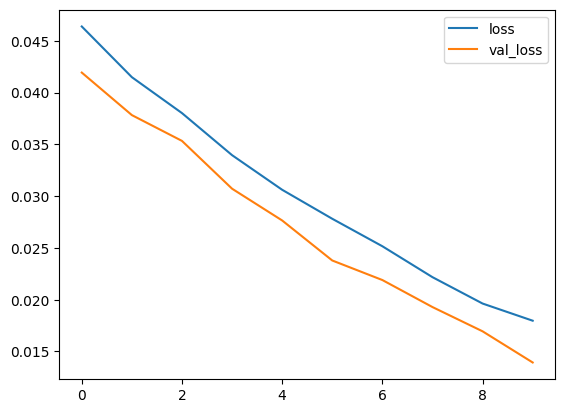

In [57]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [58]:
input_text = vectorizer("you suck")

In [59]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([  7, 396,   0, ...,   0,   0,   0], dtype=int64)>

In [60]:
result = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 2s 2s/step


In [61]:
result

array([[0.99376976, 0.13697922, 0.96449554, 0.00408057, 0.8966654 ,
        0.02689817]], dtype=float32)

In [62]:
batch_X,batch_y = test.as_numpy_iterator().next()

In [63]:
(model.predict(batch_X) > 0.5).astype(int) 

1/1 [==============================] - 0s 264ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [64]:
from tensorflow.keras.metrics import Precision, Recall,CategoricalAccuracy

In [65]:
pre = Precision()
rec = Recall()
acc = CategoricalAccuracy()

In [66]:
for batch in test.as_numpy_iterator():
  #unpack the batch
  X_true,y_true = batch
  #Make a predcition
  yhat = model.predict(X_true)

  #Flatten the predicitons
  y_true = y_true.flatten()
  yhat = yhat.flatten()

  #Updating each metrics
  pre.update_state(y_true,yhat)
  rec.update_state(y_true,yhat)
  acc.update_state(y_true,yhat)

1/1 [==============================] - 0s 115ms/step


In [67]:
print(f'Precision{pre.result().numpy()},Recall{rec.result().numpy()},Accuracy{acc.result().numpy()}')

Precision0.9255379438400269,Recall0.9321357011795044,Accuracy0.4934804439544678


In [68]:
!pip install gradio jinja2


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import gradio as gr

In [72]:
model.save('model/comments_toxicity.h5')

In [74]:
model = tf.keras.models.load_model('model/comments_toxicity.h5')

In [75]:
input_text = vectorizer('I am going to hit you')

In [76]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 1s/step


array([[0.04770481, 0.00011746, 0.01834526, 0.00996643, 0.00544237,
        0.00271201]], dtype=float32)

In [77]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx,col in enumarte(df.column[2:]):
    text += '{}:{}\n'.format(col,results[0][idx]>0.5)
  return text 

In [78]:
interface = gr.Interface(fn=score_comment, inputs = gr.inputs.Textbox(lines = 2,placeholder = 'comment to score'),outputs = 'text')


C:\Users\prasa\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\prasa\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\inputs.py:30: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
C:\Users\prasa\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\inputs.py:30: UserWarning: `numeric` parameter is deprecated, and it has no effect
  super().__init__(


In [81]:
interface.launch()

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 191ms/step


Traceback (most recent call last):
  File "C:\Users\prasa\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\routes.py", line 437, in run_predict
    output = await app.get_blocks().process_api(
  File "C:\Users\prasa\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 1346, in process_api
    result = await self.call_function(
  File "C:\Users\prasa\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 1074, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\Users\prasa\AppData\Local\Programs\Python\Python310\lib\site-packages\anyio\to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "C:\Users\prasa\AppData\Local\Programs\Python\Python310\lib\site-packages\anyio\_backends\_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "C:\Users\prasa\AppData\Local\Programs\Python\Python310\lib\site-packages\anyio\_backe